In [ ]:
#!pip install google-cloud-storage datasets lion-pytorch

In [ ]:
import json
from google.cloud import storage

def save_json(data, filename):
    with open(filename, 'w') as json_file:
      json.dump(data, json_file, indent=4)

def list_files_in_bucket(bucket_name, prefix=""):
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)

    # Print the list of file names in the bucket
    print("Files in the bucket:")
    for blob in blobs:
        print(blob.name)

def load_json_from_gcs(bucket_name, file_name):
    from google.cloud import storage
    import json

    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(file_name)

    if not file_name.endswith('.jsonl'):  # Ensure it's a JSONL file
        raise ValueError(f"The specified file '{file_name}' is not a JSONL file.")

    concatenated_data = []  # To accumulate JSON objects
    try:
        # Download and decode the file content
        content = blob.download_as_string().decode('utf-8')
        # Split content by lines and load each line as a separate JSON object
        for line in content.splitlines():
            if line.strip():  # Only parse non-empty lines
                json_obj = json.loads(line)
                concatenated_data.append(json_obj)  # Add JSON object to the list
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {file_name}: {e}")

    # Return the JSON as a string for output
    return json.dumps(concatenated_data, indent=4)  # Prettify the JSON output

def load_csv_from_gcs(bucket_name, file_name):
    from google.cloud import storage
    import pandas as pd
    from io import StringIO  # Corrected import for StringIO

    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(file_name)

    if not file_name.endswith('.csv'):  # Ensure it's a CSV file
        raise ValueError(f"The specified file '{file_name}' is not a CSV file.")

    try:
        # Download CSV content and load it into a pandas DataFrame
        content = blob.download_as_string().decode('utf-8')
        data = pd.read_csv(StringIO(content))  # Use StringIO to parse the CSV content
    except Exception as e:
        print(f"Error loading CSV file '{file_name}': {e}")
        return None

    return data


def save_csv_to_gcs(bucket_name, file_name, dataframe):
    from google.cloud import storage
    import pandas as pd

    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(file_name)

    if not file_name.endswith('.csv'):  # Ensure it's a CSV file
        raise ValueError(f"The specified file '{file_name}' is not a CSV file.")

    try:
        # Convert the DataFrame to CSV and upload it to GCS
        csv_content = dataframe.to_csv(index=False)  # Convert DataFrame to CSV string
        blob.upload_from_string(csv_content, content_type='text/csv')
        print(f"File '{file_name}' successfully saved to bucket '{bucket_name}'.")
    except Exception as e:
        print(f"Error saving CSV file '{file_name}': {e}")

In [ ]:
train_data = load_csv_from_gcs("mddi-reach-conversation", "training_data/train.csv")
#augmented_agree = load_csv_from_gcs("mddi-reach-conversation", "data/augmented_agree.csv")
augmented_full_df = load_csv_from_gcs("mddi-reach-conversation", "data/augmented_full_df.csv")
test_data = load_csv_from_gcs("mddi-reach-conversation", "training_data/test.csv")
vali_data = load_csv_from_gcs("mddi-reach-conversation", "training_data/vali.csv")

augmented_full_df = augmented_full_df.drop(columns=["label"]).rename({"class": "label"}, axis=1)
train_data.tail()

,pid,chat_group_id,timestamp,topic,content,topic_group,context,group_user,group,user,stance,human_label,agreement,label,label_description
20487,0f88e4bf-dda5-46b6-b760-f23070605cfa,7,2023/08/10 18:53:00,*国庆献词*\n\n政府将调整组屋政策，确保政策公平和包容，同时完善公积金制度，确保年长会员...,1。家人相互照顾是幸福。\n2，3，4： 如果无亲友在照顾，空巢老人最终也需要福利部的帮助。...,national_day,运用科技，药物 和其他人力支援整个养老过程，包括最后的临终护理， 我们还是可以平安的离开。 ...,70f88e4bf-dda5-46b6-b760-f23070605cfa,7,0f88e4bf-dda5-46b6-b760-f23070605cfa,I trust in this Government's credibility,no opinion,majority,0,NaN
20488,0f88e4bf-dda5-46b6-b760-f23070605cfa,7,2023/08/10 18:53:00,*国庆献词*\n\n政府将调整组屋政策，确保政策公平和包容，同时完善公积金制度，确保年长会员...,1。家人相互照顾是幸福。\n2，3，4： 如果无亲友在照顾，空巢老人最终也需要福利部的帮助。...,national_day,运用科技，药物 和其他人力支援整个养老过程，包括最后的临终护理， 我们还是可以平安的离开。 ...,70f88e4bf-dda5-46b6-b760-f23070605cfa,7,0f88e4bf-dda5-46b6-b760-f23070605cfa,The Government should provide more job opportu...,no opinion,unanimous,0,NaN
20489,0f88e4bf-dda5-46b6-b760-f23070605cfa,7,2023/08/10 18:53:00,*国庆献词*\n\n政府将调整组屋政策，确保政策公平和包容，同时完善公积金制度，确保年长会员...,1。家人相互照顾是幸福。\n2，3，4： 如果无亲友在照顾，空巢老人最终也需要福利部的帮助。...,national_day,运用科技，药物 和其他人力支援整个养老过程，包括最后的临终护理， 我们还是可以平安的离开。 ...,70f88e4bf-dda5-46b6-b760-f23070605cfa,7,0f88e4bf-dda5-46b6-b760-f23070605cfa,The Government should support local workers more,no opinion,unanimous,0,NaN
20490,8eca1c95-186e-4a04-803a-addd5b9a9a3b,7,2023/08/10 18:57:00,*国庆献词*\n\n政府将调整组屋政策，确保政策公平和包容，同时完善公积金制度，确保年长会员...,整个贷款结束时，您将有一种自豪感和成就感，并对多年的辛勤工作有了新的认识。\n\n从那时起，...,national_day,日间托老所不实际，有开放的时间限制。 [SEP] 适合有家人但需工作或休息时间的。其实很多工...,78eca1c95-186e-4a04-803a-addd5b9a9a3b,7,8eca1c95-186e-4a04-803a-addd5b9a9a3b,The Government should provide more job opportu...,no opinion,unanimous,0,NaN
20491,8eca1c95-186e-4a04-803a-addd5b9a9a3b,7,2023/08/10 18:57:00,*国庆献词*\n\n政府将调整组屋政策，确保政策公平和包容，同时完善公积金制度，确保年长会员...,整个贷款结束时，您将有一种自豪感和成就感，并对多年的辛勤工作有了新的认识。\n\n从那时起，...,national_day,日间托老所不实际，有开放的时间限制。 [SEP] 适合有家人但需工作或休息时间的。其实很多工...,78eca1c95-186e-4a04-803a-addd5b9a9a3b,7,8eca1c95-186e-4a04-803a-addd5b9a9a3b,The Government should support local workers more,no opinion,unanimous,0,NaN


In [ ]:
train_data['context'] = train_data['context'].fillna(train_data['topic'])
test_data['context'] = test_data['context'].fillna(vali_data['topic'])
vali_data['context'] = vali_data['context'].fillna(vali_data['topic'])

In [ ]:
train_data.columns, augmented_full_df.columns

(Index(['pid', 'chat_group_id', 'timestamp', 'topic', 'content', 'topic_group',
        'context', 'group_user', 'group', 'user', 'stance', 'human_label',
        'agreement', 'label', 'label_description'],
       dtype='object'),
 Index(['chat_group_id', 'stance', 'content', 'human_label', 'label',
        'context'],
       dtype='object'))

In [ ]:
train_data.groupby("label")["label"].count()

,label
label,
0,19661
1,831


In [ ]:
import pandas as pd
#df = pd.concat([train_data, augmented_full_df, augmented_agree]).reset_index(drop=True)
df = pd.concat([train_data, augmented_full_df]).reset_index(drop=True)
df.tail()

,pid,chat_group_id,timestamp,topic,content,topic_group,context,group_user,group,user,stance,human_label,agreement,label,label_description
92674,NaN,7261,NaN,NaN,"Flexibility attracts many, regulations might k...",NaN,"It's just like having a safety net, right? Eve...",NaN,NaN,NaN,The Government should prioritize the implement...,disagree,NaN,0,NaN
92675,NaN,7261,NaN,NaN,Gig economy promotes flexibility and independe...,NaN,"Wah, if all these gig workers get better pay a...",NaN,NaN,NaN,The Government should prioritize the implement...,disagree,NaN,0,NaN
92676,NaN,7261,NaN,NaN,如果政府能出台更好的政策，给gig economy的工人更公平的待遇，可能会让更多人愿意参与...,NaN,这事儿可能复杂一点，可能要考虑到平台的灵活性和创新空间吧。 [SEP] Flexibilit...,NaN,NaN,NaN,The Government should prioritize the implement...,no opinion,NaN,0,NaN
92677,NaN,7261,NaN,NaN,"Wah, totally need more rules leh, no fair for ...",NaN,"Flexibility attracts many, regulations might k...",NaN,NaN,NaN,The Government should prioritize the implement...,agree,NaN,1,NaN
92678,NaN,7261,NaN,NaN,"Gig work still very uncertain, must have rules...",NaN,Gig economy promotes flexibility and independe...,NaN,NaN,NaN,The Government should prioritize the implement...,agree,NaN,1,NaN


In [ ]:
df.count()

,0
pid,20492
chat_group_id,92679
timestamp,20492
topic,20492
content,92679
topic_group,20492
context,85425
group_user,20492
group,20492
user,20492


In [ ]:
def reverse_sep_string(input_str):
    # Split the string by '[SEP]'
    if type(input_str)!=str:
      return ""
    else:
      elements = input_str.split('[SEP]')
      # Reverse the list of elements
      reversed_elements = elements[::-1]
      # Join them back with '[SEP]'
      return '[SEP]'.join(reversed_elements)

df["context"] = df["context"].apply(reverse_sep_string)
test_data["context"] = test_data["context"].apply(reverse_sep_string)
vali_data["context"] = vali_data["context"].apply(reverse_sep_string)

In [ ]:
rename = {"content": "sentence1", "stance": "sentence2","context": "sentence3",}
columns = ["sentence1", "sentence2", "sentence3", "label"]
train_df = df.rename(columns=rename)[columns]
test_df = test_data.rename(columns=rename)[columns]
vali_df = vali_data.rename(columns=rename)[columns]
train_df.head()

,sentence1,sentence2,sentence3,label
0,"It is just a one off payment. In the long run,...",The Government is giving out too much social s...,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,0
1,"It is just a one off payment. In the long run,...",The Government should provide more employment ...,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,0
2,"It is just a one off payment. In the long run,...",The Working Mother Child Relief (WMCR) should ...,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,0
3,"It is just a one off payment. In the long run,...",There should be more government support for st...,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,0
4,"It is just a one off payment. In the long run,...",I support the Goods & Services Tax (GST) Vouch...,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,0


In [ ]:
train_df.groupby("label")["label"].count()

,label
label,
0,59337
1,33342


# Training Scripts

## Cross-Encoder

In [ ]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer


def tokenize_dataset(df, tokenizer, device, max_length=512):
    """
    Tokenizes the dataset using the specified tokenizer.

    Args:
        dataset (Dataset): The Hugging Face dataset to be tokenized.
        tokenizer (AutoTokenizer): Tokenizer from Hugging Face Transformers.
        max_length (int): Maximum sequence length for padding/truncation.

    Returns:
        Dataset: Tokenized Hugging Face dataset.
    """
    # Define the tokenization function
    def tokenize_function(examples, device):
        inputs = tokenizer(
            examples,
            padding="max_length",
            max_length=max_length,
            truncation="longest_first",
            return_tensors="pt",

        )
        return {key: value.to(device) for key, value in inputs.items()}

    df['sentence1'] = df['sentence1'].apply(lambda x: str(x))
    df['sentence2'] = df['sentence2'].apply(lambda x: str(x))
    df['sentence3'] = df['sentence3'].apply(lambda x: str(x))
    df["combined_input"] = df[["sentence1", "sentence3"]].apply(lambda x: x[0]+ " [SEP] " + x[1], axis=1)
    inputs = df[["combined_input", 'sentence2']].values.tolist()
    '''
    tokenized_example = {
        'input_ids': [],
        'attention_mask': []
    }
    '''
    tokenized = tokenize_function(inputs, device)
    #tokenized_example['input_ids'].append(tokenized['input_ids'])
    #okenized_example['attention_mask'].append(tokenized['attention_mask'])
    # Create a new dataset from the tokenized data
    tokenized_dataset = Dataset.from_dict(tokenized)
    tokenized_dataset = tokenized_dataset.add_column('label', df['label'])
    return tokenized_dataset

def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
    """
    Splits the dataset into training, validation, and test sets.

    Args:
        dataset (Dataset): The tokenized dataset to be split.
        train_ratio (float): Ratio of the training set.
        val_ratio (float): Ratio of the validation set.

    Returns:
        DatasetDict: A dictionary containing train, validation, and test datasets.
    """
    # Calculate split sizes
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # Split the dataset
    split_datasets = dataset.train_test_split(test_size=test_size + val_size, seed=42)
    val_test_split = split_datasets['test'].train_test_split(test_size=test_size, seed=42)

    # Combine splits into a DatasetDict
    dataset_dict = DatasetDict({
        'train': split_datasets['train'],
        'validation': val_test_split['train'],
        'test': val_test_split['test']
    })

    return dataset_dict

In [ ]:
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import nn
from tqdm.autonotebook import tqdm, trange
import torch
from sentence_transformers.SentenceTransformer import SentenceTransformer
import numpy as np
import logging
import torch.nn.functional as F
import time
from transformers import get_scheduler
from collections import Counter



from typing import Callable
from torch.optim import Optimizer
from sentence_transformers.evaluation.SentenceEvaluator import SentenceEvaluator

class CrossEncoderForMultiClass():
    def __init__(
        self,
        model_name: str,
        num_labels: int = None,
        batch_size: int = 32,
        output_path: str = None
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if num_labels > 1:
          ignore_mismatched_sizes = True
        else:
          ignore_mismatched_sizes = False
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels = num_labels,
            ignore_mismatched_sizes=ignore_mismatched_sizes,
        ).to(device)
        self.num_labels= num_labels
        print("Model loaded successfully")

        self.model.to(self.device)
        self.batch_size = batch_size
        self.output_path = output_path

        # Create the output path if it doesn't exist
        if output_path is not None:
            os.makedirs(output_path, exist_ok=True)

    def create_batch(self, dataset, batch_size=None, shuffle=True, stratified=True):
        if batch_size is None:
            batch_size = self.batch_size

        # If shuffle is True, shuffle the dataset first
        if shuffle:
            dataset = dataset.shuffle(seed=42)  # Shuffle with a seed for reproducibility

        # Set the format for Hugging Face datasets (before passing to DataLoader)
        dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

        if stratified:
            # Get the labels and calculate the class distribution
            labels = np.array(dataset['label'])  # Convert labels to numpy array
            class_counts = torch.tensor([sum(labels == i) for i in set(labels)])  # Count each class
            class_weights = 1.0 / class_counts  # Calculate inverse frequency (more weight for less frequent classes)
            sample_weights = class_weights[labels]  # Assign a weight to each sample based on its label

            # Create a WeightedRandomSampler for stratified sampling
            sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

            # Create the DataLoader using the sampler
            dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

        else:
            # Without stratified sampling
            dataloader = DataLoader(dataset, batch_size=batch_size)

        return dataloader

    def fit(
        self,
        train_data: DataLoader,
        evaluator: SentenceEvaluator = None,
        epochs: int = 1,
        loss_fct=None,
        #activation_fct = nn.Identity(),
        scheduler: str = "WarmupLinear",
        warmup_steps: int = 10000,
        optimizer_class: type[Optimizer] = torch.optim.AdamW,
        optimizer_params: dict[str, object] = {"lr": 2e-5},
        weight_decay: float = 0.01,
        evaluation_steps: int = 0,
        save_best_model: bool = True,
        max_grad_norm: float = 1,
        #use_amp: bool = False,
        callback: Callable[[float, int, int], None] = None,
        show_progress_bar: bool = True,
    ):

        # Initialize variables
        self.best_score = -9999999
        num_train_steps = int(len(train_data) * epochs)


        # Define the loss function
        if loss_fct is None:
            # Initialize counters
            #N_pos = 0
            #N_neg = 0

            # Iterate through the dataloader
            #for batch in train_dataloader:
            #    targets = batch["label"]
            #    # Assuming targets are binary (0 or 1)
            #    N_pos += sum(targets == 1)
            #    N_neg += sum(targets == 0)
            #pos_weight = torch.tensor([N_neg / N_pos])

            loss_fct = nn.BCEWithLogitsLoss() if self.num_labels == 1 else nn.CrossEntropyLoss()

        # Prepare optimizer and scheduler
        param_optimizer = list(self.model.named_parameters())

        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                "weight_decay": weight_decay,
            },
            {"params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
        ]

        optimizer = optimizer_class(optimizer_grouped_parameters, **optimizer_params)

        if isinstance(scheduler, str):
            scheduler_optimizer = SentenceTransformer._get_scheduler(
                optimizer, scheduler=scheduler, warmup_steps=warmup_steps, t_total=num_train_steps
            )
        print("Starting model training...")
        training_steps = 0
        for epoch in trange(epochs, desc="Epoch", disable=not show_progress_bar):

            # Create dataloader shuffled
            train_dataloader = self.create_batch(train_data, batch_size = self.batch_size)

            self.model.zero_grad()
            self.model.train()
            loss_values = []

            for batch in tqdm(
                train_dataloader, desc="Iteration", smoothing=0.05, disable=not show_progress_bar
            ):
                batch_start_time = time.time()
                # Move batch to device
                features = {k: torch.Tensor(v).to(self.device) for k, v in batch.items() if k != 'label'}
                labels = batch['label'].to(self.device)

                self.model.train()
                optimizer.zero_grad()
                model_predictions = self.model(**features, return_dict=True)

                if self.num_labels == 1:
                    #logits =  F.softmax(model_predictions.logits, dim = 0)
                    logits = model_predictions.logits.view(-1).float()
                    labels = labels.float()
                #else:
                #    logits =  F.softmax(model_predictions.logits, dim = 1).float()
                loss_value = loss_fct(logits, labels)
                loss_value.backward()
                #torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_grad_norm)
                optimizer.step()
                scheduler_optimizer.step()
                optimizer.zero_grad()

                training_steps += 1
                loss_values.append(loss_value.item())
                batch_end_time = time.time()

                if evaluator is not None and evaluation_steps > 0 and training_steps % evaluation_steps == 0:
                    self.model.eval()
                    self._eval_during_training(
                        evaluator, sum(loss_values)/len(loss_values), batch_end_time-batch_start_time, save_best_model, epoch, training_steps
                    )

                    self.model.zero_grad()
                    self.model.train()
    def predict(
        self,
        dataset,
        batch_size: int = 32,
        show_progress_bar = None,
        #num_workers: int = 0,
        #activation_fct = None,
        #apply_softmax = False,
        convert_to_numpy: bool = True,
        convert_to_tensor: bool = False,
        output_prob = True
    ):
        """
        Performs predictions with the CrossEncoder on the given sentence pairs.

        Args:
            sentences (Union[List[Tuple[str, str]], Tuple[str, str]]): A list of sentence pairs [(Sent1, Sent2), (Sent3, Sent4)]
                or one sentence pair (Sent1, Sent2).
            batch_size (int, optional): Batch size for encoding. Defaults to 32.
            show_progress_bar (bool, optional): Output progress bar. Defaults to None.
            num_workers (int, optional): Number of workers for tokenization. Defaults to 0.
            activation_fct (callable, optional): Activation function applied on the logits output of the CrossEncoder.
                If None, nn.Sigmoid() will be used if num_labels=1, else nn.Identity. Defaults to None.
            convert_to_numpy (bool, optional): Convert the output to a numpy matrix. Defaults to True.
            apply_softmax (bool, optional): If there are more than 2 dimensions and apply_softmax=True,
                applies softmax on the logits output. Defaults to False.
            convert_to_tensor (bool, optional): Convert the output to a tensor. Defaults to False.

        Returns:
            Union[List[float], np.ndarray, torch.Tensor]: Predictions for the passed sentence pairs.
            The return type depends on the `convert_to_numpy` and `convert_to_tensor` parameters.
            If `convert_to_tensor` is True, the output will be a torch.Tensor.
            If `convert_to_numpy` is True, the output will be a numpy.ndarray.
            Otherwise, the output will be a list of float values.

        Examples:
            ::

                from sentence_transformers import CrossEncoder

                model = CrossEncoder("cross-encoder/stsb-roberta-base")
                sentences = [["I love cats", "Cats are amazing"], ["I prefer dogs", "Dogs are loyal"]]
                model.predict(sentences)
                # => array([0.6912767, 0.4303499], dtype=float32)
        """
        dataset = self.create_batch(dataset, batch_size = batch_size, shuffle=False, stratified=False)

        pred_scores = []
        self.model.eval()
        self.model.to(self.device)
        with torch.no_grad():
           for batch in tqdm(
                dataset, desc="Iteration", smoothing=0.05, disable=not show_progress_bar
            ):
                features = {k: torch.Tensor(v).to(self.device) for k, v in batch.items() if k != 'label'}
                model_predictions = self.model(**features, return_dict=True)
                #logits = activation_fct(model_predictions.logits)

                #if apply_softmax and len(logits[0]) > 1:
                if output_prob:
                    if self.num_labels == 1:
                        logits = torch.sigmoid(model_predictions.logits)
                    else:
                        logits = F.softmax(model_predictions.logits, dim=1)
                else:
                    logits = model_predictions.logits
                pred_scores.extend(logits)

        if self.num_labels == 1:
            pred_scores = [score[0].cpu() for score in pred_scores]
            if convert_to_tensor:
              pred_scores = torch.Tensor(pred_scores)
            elif convert_to_numpy:
              pred_scores = np.array(pred_scores)
        else:
            if convert_to_tensor:
                pred_scores = torch.stack(pred_scores)
            elif convert_to_numpy:
                pred_scores = np.asarray([score.cpu().detach().float().numpy() for score in pred_scores])

        return pred_scores


    def _eval_during_training(self, evaluator, train_loss, time, save_best_model, epoch, steps) -> None:
        """Runs evaluation during the training"""
        if evaluator is not None:
            score = evaluator(self, train_loss, time, epoch=epoch, steps=steps)
            #if callback is not None:
            #    callback(score, epoch, steps)
            saved_model = False
            if score["vali_auc"] > self.best_score:
                self.best_score = score["vali_auc"]
                if save_best_model:
                    self.save(self.output_path)
                    #saved_model = True

            if save_best_model:
                if saved_model == False:
                    self.save(self.output_path)


    def save(self, path: str, *, safe_serialization: bool = True, **kwargs) -> None:
        """
        Saves the model and tokenizer to path; identical to `save_pretrained`
        """

        print(f"Save model to {path}")
        self.model.save_pretrained(path, safe_serialization=safe_serialization, **kwargs)
        self.tokenizer.save_pretrained(path, **kwargs)



In [ ]:
#import csv
import logging
import os
from contextlib import nullcontext
from typing import TYPE_CHECKING
import json
import wandb
from sklearn.preprocessing import LabelBinarizer
from sentence_transformers.evaluation.SentenceEvaluator import SentenceEvaluator
from sentence_transformers import SentenceTransformer

if TYPE_CHECKING:
    from sentence_transformers.SentenceTransformer import SentenceTransformer

logger = logging.getLogger(__name__)


class CrossEncoderEvaluator(SentenceEvaluator):

    def __init__(
        self,
        val_dataloader,
        metrics_save_path,
        name: str = "",
        batch_size: int = 32,
        show_progress_bar: bool = False,
        loss_fn = nn.CrossEntropyLoss()
        #write_csv: bool = True,
        #truncate_dim: int | None = None,
    ):
        self.val_dataloader= val_dataloader
        self.labels = val_dataloader["label"]
        self.name = name
        self.batch_size = batch_size

        self.show_progress_bar = show_progress_bar
        self.loss_fn = loss_fn
        self.json_file = metrics_save_path

    def append_to_json(self, file_path, new_dict, overwrite = False):
        # Check if the file exists
        if overwrite == False:
            if os.path.exists(file_path):
                # Open and load existing JSON data
                with open(file_path, 'r') as file:
                    data = json.load(file)

                # Ensure data is a list
                if not isinstance(data, list):
                    raise ValueError("JSON file must contain a list of dictionaries.")
            else:
                # If file doesn't exist, start with an empty list
                data = []

            # Append the new dictionary
            data.append(new_dict)
        else:
            data = new_dict

        # Ensure the directory exists
        folder_path = os.path.dirname(file_path)
        if folder_path:  # Check if there is a folder path in file_path
            os.makedirs(folder_path, exist_ok=True)
        # Save the updated data back to the file
        with open(file_path, 'w') as file:
            json.dump(data, file)

    def __call__(
        self,
        model: SentenceTransformer,
        train_loss,
        time,
        epoch: int = -1,
        steps: int = -1
    ) -> dict[str, float]:

        if epoch != -1:
            if steps == -1:
                out_txt = f" after epoch {epoch}"
            else:
                out_txt = f" in epoch {epoch} after {steps} steps"
        else:
            out_txt = ""
        #if self.truncate_dim is not None:
        #    out_txt += f" (truncated to {self.truncate_dim})"

        scores = self.compute_metrices(model)
        scores["train_loss"] = train_loss

        print(f"Epoch: {epoch}, step: {steps}, time: {time}, scores: ", scores)
        scores["epoch"] = epoch
        scores["steps"] = steps

        scores["train_time"] = time

        wandb.log(scores)
        self.append_to_json(self.json_file, scores)

        return scores

    def compute_metrices(self, model):

        scores = model.predict(self.val_dataloader, output_prob = False, batch_size = self.batch_size)

        not_binary = len(np.array(scores).shape)>1
        y_true = np.asarray(self.labels)

        if not_binary:
            y_scores = np.array(F.softmax(torch.Tensor(scores), dim=1))
            y_pred = np.argmax(scores, axis=1)
        else:
            y_scores = np.array(torch.sigmoid(torch.Tensor(scores)))
            precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

            # Calculate F1-Score for each threshold
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
            best_idx = np.argmax(f1_scores)
            best_threshold = thresholds[best_idx]

            y_pred = (y_scores >best_threshold).astype(int)
            #with open("content/output.txt", "w") as f:

            #  for item in y_true:
            #      f.write(f"{item}\n")

            #  for item in y_scores:
            #      f.write(f"{item}\n")

            #  for item in y_pred:
            #      f.write(f"{item}\n")

        output_scores = {}
        #display(y_true, y_scores, y_pred, scores)

        # Calculate metrics with 'weighted' average to account for class imbalance
        f1 = f1_score(y_true, y_pred, zero_division=1)
        precision = precision_score(y_true, y_pred, zero_division=1)
        recall = recall_score(y_true, y_pred, zero_division=1)
        pr_auc = None
        # Calculate AUC score (weighted-average)
        auc_score = 0
        if not_binary:
            # Binarize labels for AUC calculation
            n_classes = len(scores[0])
            y_true_binarized = label_binarize(y_true, classes=range(n_classes))
            # Filter scores and true labels to only include classes present in y_true
            present_classes = np.unique(y_true)  # Get classes present in y_true
            y_true_binarized_filtered = y_true_binarized[:, present_classes]  # Filter y_true_binarized
            scores_filtered = np.array(y_scores)[:, present_classes]  # Filter scores

            # Calculate the AUC score using 'ovr' (One-vs-Rest)
            auc_score = roc_auc_score(y_true_binarized_filtered, scores_filtered, average='weighted', multi_class='ovr')
            loss = self.loss_fn(torch.Tensor(scores).float(), torch.Tensor(self.labels).long())
        else:
            auc_score = roc_auc_score(y_true, y_scores)
            pr_precision, pr_recall,  pr_thresholds = precision_recall_curve(y_true, y_scores)
            pr_auc = auc( pr_recall,  pr_precision)
            loss = self.loss_fn(torch.Tensor(scores).float(), torch.Tensor(self.labels).float())


        output_scores = {
            "vali_f1": f1,
            "vali_auc": auc_score,
            "vali_precision": precision,
            "vali_recall": recall,
            "vali_loss": loss.item(),
            "weighted_precision":  precision_score(y_true, y_pred, zero_division=1, average = "weighted"),
            "weighted_recall":  recall_score(y_true, y_pred, zero_division=1, average = "weighted"),
            "weighted_f1":  f1_score(y_true, y_pred, zero_division=1, average = "weighted"),
            "macro_precision":  precision_score(y_true, y_pred, zero_division=1, average = "macro"),
            "macro_recall":  recall_score(y_true, y_pred, zero_division=1, average = "macro"),
            "macro_f1":  f1_score(y_true, y_pred, zero_division=1, average = "macro")
        }
        if pr_auc:
            output_scores["pr_auc"] = pr_auc
        return output_scores

In [ ]:
import torch
import torch.nn as nn
from lion_pytorch import Lion
import wandb
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    auc
)
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer, label_binarize

class CrossEncoderTrainer():
    def __init__(self,
                  project_name,
                  model_name,
                  num_labels,
                  epochs,
                  lr,
                  train_batch_size,
                  eval_batch_size,
                  warmup_steps,
                  model_save_path,
                  metrics_save_path,
                  weight_decay = 0,
                  evaluation_steps = 100,
                  optimizer_class = "adam",
                  scheduler = None,
                  version = "v1"
              ):
        self.num_labels = num_labels
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = CrossEncoderForMultiClass(
              model_name = model_name,
              num_labels = num_labels,
              batch_size = train_batch_size,
              output_path = model_save_path
        )
        self.model_name = model_name
        self.loss = nn.BCEWithLogitsLoss() if num_labels == 1 else nn.CrossEntropyLoss()
        self.epochs = epochs
        self.warmup_steps = warmup_steps
        self.optimizer_params  = {"lr": lr}
        self.eval_batch_size = eval_batch_size
        self.evaluation_steps = evaluation_steps
        self.weight_decay = weight_decay
        if optimizer_class == "adam":
              self.optimizer_class = torch.optim.AdamW
        elif optimizer_class == "lion":
              self.optimizer_class = Lion
        self.model_save_path = model_save_path
        # Initialize WandB
        config = {
              "model_name": model_name,
              "learning_rate": lr,
              "epochs": epochs,
              "warmup_steps": warmup_steps,
              "evaluation_steps": evaluation_steps,
              "weight_decay": weight_decay,
              "optimizer_class": optimizer_class,
              "batch_size": train_batch_size,
        }
        run_name = self.model_name +  datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        metrics_save_path = (metrics_save_path + "/") if (metrics_save_path[-1] != "/") else metrics_save_path
        self.json_file = metrics_save_path + ("classification_evaluation" + ("_" + model_name if model_name else "") + "_" + version + "_results.json").replace("/", "_")

        wandb.init(
              project=project_name,
              name= run_name[:255],
              config= config
        )

    def train(self,
              train_dataloader,
              eval_dataloader
                        ):
        evaluator = CrossEncoderEvaluator(
              eval_dataloader,
              name = self.model_name,
              batch_size = self.eval_batch_size,
              show_progress_bar= True,
              metrics_save_path=self.json_file,
              loss_fn= self.loss
        )
        print("Training model")
        self.model.fit(
              train_data=train_dataloader,
              evaluator=evaluator,
              evaluation_steps =self.evaluation_steps,
              optimizer_params= self.optimizer_params,
              loss_fct  = self.loss,
              epochs=self.epochs,
              warmup_steps=self.warmup_steps,
              save_best_model = True,
              #callback = self.callback,
              show_progress_bar = True,
              scheduler = scheduler
        )


    def compute_metrics(self, y_true, y_pred, best_threshold = 0.5):
        """
        Computes metrics for binary and multi-class classification tasks.

        Args:
            y_true: Array of true labels.
            y_pred: Array of predicted probabilities or class predictions.

        Returns:
            Dictionary containing per-class metrics and weighted averages.
        """
        y_pred = np.array(y_pred)


        # Determine if the task is binary or multi-class
        is_binary = len(y_pred.shape) == 1 or y_pred.shape[1] == 1
        if is_binary:
            # For binary, convert probabilities to binary predictions
            if len(y_pred.shape) > 1:  # If y_pred is 2D (e.g., [[0.3], [0.7]]))
                y_pred = y_pred.flatten()
            y_pred_class = (y_pred >= best_threshold).astype(int)
            num_classes = 2
        else:
            # For multi-class, use argmax to get class predictions
            y_pred_class = np.argmax(y_pred, axis=1)
            num_classes = y_pred.shape[1]

        # Binarize true labels for multi-class AUC calculation
        y_true_bin = label_binarize(y_true, classes=range(num_classes))

        # Initialize metrics container
        metrics_per_class = {
            "f1_per_class": [],
            "precision_per_class": [],
            "recall_per_class": [],
            "auc_per_class": [],
        }

        # Compute metrics for each class
        for i in range(num_classes):
            # Compute metrics for the current class
            if is_binary:
                f1 = f1_score(y_true, y_pred_class, pos_label=i)
                precision = precision_score(y_true, y_pred_class, pos_label=i)
                recall = recall_score(y_true, y_pred_class, pos_label=i)
            else:
                f1 = f1_score(y_true, y_pred_class, labels=[i], average="marco")
                precision = precision_score(y_true, y_pred_class, labels=[i], average="marco")
                recall = recall_score(y_true, y_pred_class, labels=[i], average="marco")

            # Compute AUC for the current class
            if is_binary:
                auc_score = roc_auc_score(y_true, y_pred)  # Overall AUC for binary case
            else:
                auc_score = roc_auc_score(y_true_bin[:, i], y_pred[:, i])  # AUC for each class in multi-class

            # Store metrics
            metrics_per_class["f1_per_class"].append(f1)
            metrics_per_class["precision_per_class"].append(precision)
            metrics_per_class["recall_per_class"].append(recall)
            metrics_per_class["auc_per_class"].append(auc_score)

        # Compute AUC for the entire dataset (non-weighted)
        if is_binary:
            auc_non_weighted = roc_auc_score(y_true, y_pred)

        else:
            auc_non_weighted = roc_auc_score(y_true_bin, y_pred, average='macro', multi_class='ovr')

        # Compute weighted averages
        #weights = np.bincount(y_true) / len(y_true)
        #weighted_avg = {
        #    "f1_weighted": np.average(metrics_per_class["f1_per_class"], weights=weights),
        #    "precision_weighted": np.average(metrics_per_class["precision_per_class"], weights=weights),
        #    "recall_weighted": np.average(metrics_per_class["recall_per_class"], weights=weights),
        #    "auc_weighted": np.average(metrics_per_class["auc_per_class"], weights=weights),
        #}

        # Compute non-weighted averages (same weight across classes)
        non_weighted_avg = {
            "f1": f1_score(y_true, y_pred_class),
            "precision": precision_score(y_true, y_pred_class),
            "recall": recall_score(y_true, y_pred_class),
            "auc": roc_auc_score(y_true, y_pred),
            "weighted_precision":  precision_score(y_true, y_pred_class, zero_division=1, average = "macro"),
            "weighted_recall":  recall_score(y_true, y_pred_class, zero_division=1, average = "macro"),
            "weighted_f1":  f1_score(y_true, y_pred_class, zero_division=1, average = "macro")
        }
        plt.figure(figsize=(10, 8))
        # Plotting ROC curve for each class (if multi-class)
        if is_binary:
            fpr, tpr, _ = precision_recall_curve(y_true, y_pred)
            avg_precision = average_precision_score(y_true, y_pred)
            # Plot the Precision-Recall curve
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, marker='.', label=f'AP = {avg_precision:.2f}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend()
            plt.grid()
            plt.show()
            plt.clf()
        else:
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
                plt.plot(fpr, tpr, label=f'Class {i} (AUC = {metrics_per_class["auc_per_class"][i]:.2f})')

            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc='best')
            plt.grid()
            plt.show()
            plt.clf()

        # Combine metrics into a single dictionary for logging
        result_metrics = {**metrics_per_class, **non_weighted_avg}
        return result_metrics

    def test(self,
            test_dataloader,
            results_save_path,
            vali_dataloader
            ):
        model = CrossEncoderForMultiClass(
              self.model_save_path,
              num_labels=self.num_labels,
              output_path=self.model_save_path
              )
        labels = np.array(test_dataloader['label'])

        scores = model.predict(test_dataloader, output_prob=True, batch_size = self.eval_batch_size)

        not_binary = len(np.array(scores).shape)>1
        best_threshold= 0.5
        if not_binary==False:
            vali_scores = model.predict(vali_dataloader, output_prob = True)
            precision, recall, thresholds = precision_recall_curve(labels, scores)

            # Calculate F1-Score for each threshold
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
            best_idx = np.argmax(f1_scores)  # Index of the maximum F1-Score
            best_threshold = thresholds[best_idx]


        #scores = model.predict(test_dataloader, output_prob = True)

        test_metrics = self.compute_metrics(labels, scores, best_threshold= best_threshold)

        print("Test Scores: ", test_metrics)
        wandb.log(test_metrics)
        json_data = json.dumps(test_metrics, indent=4)
        with open(results_save_path, "w") as file:
              file.write(json_data)
        return scores, best_threshold

    def plot_validation_metrics(self):
        with open(self.json_file, "r") as file:
            data = json.load(file)
        data = sorted(data, key=lambda x: x['steps'])
        # Convert the list of dictionaries into a DataFrame
        steps = [entry['steps'] for entry in data]
        train_loss = [entry['train_loss'] for entry in data]
        vali_loss = [entry['vali_loss'] for entry in data]
        precision = [entry['vali_precision'] for entry in data]
        recall = [entry['vali_recall'] for entry in data]
        f1 = [entry['vali_f1'] for entry in data]
        auc = [entry['vali_auc'] for entry in data]


        # Plot the losses by steps
        plt.figure(figsize=(10, 5))
        plt.plot(steps, train_loss, label='Training Loss')
        plt.plot(steps, vali_loss, label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Losses by Steps')
        plt.ylim(0,max(vali_loss))
        plt.xlim(0,max(steps))
        plt.legend()
        plt.show()
        plt.clf()

        # Plot the other metrics (excluding epochs) by steps
        plt.figure(figsize=(10, 5))
        plt.plot(steps,f1, label='Validation F1')
        plt.plot(steps, auc, label='Validation AUC')
        plt.plot(steps, precision, label='Validation Precision')
        plt.plot(steps, recall, label='Validation Recall')
        plt.ylim(0,1)
        plt.xlim(0,max(steps))
        plt.xlabel('Steps')
        plt.ylabel('Metrics')
        plt.title('Validation Metrics by Steps')
        plt.legend()
        plt.show()
        plt.clf()

In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Check current device ID
print(torch.cuda.get_device_name(0))  # Should return your GPU model

True
0
NVIDIA A100-SXM4-40GB


In [ ]:
model_name = "cross-encoder/mmarco-mMiniLMv2-L12-H384-v1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import torch
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels = 1,
            ignore_mismatched_sizes=True)

for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)
model.to(device)

roberta.embeddings.word_embeddings.weight torch.Size([250002, 384]) True
roberta.embeddings.position_embeddings.weight torch.Size([514, 384]) True
roberta.embeddings.token_type_embeddings.weight torch.Size([1, 384]) True
roberta.embeddings.LayerNorm.weight torch.Size([384]) True
roberta.embeddings.LayerNorm.bias torch.Size([384]) True
roberta.encoder.layer.0.attention.self.query.weight torch.Size([384, 384]) True
roberta.encoder.layer.0.attention.self.query.bias torch.Size([384]) True
roberta.encoder.layer.0.attention.self.key.weight torch.Size([384, 384]) True
roberta.encoder.layer.0.attention.self.key.bias torch.Size([384]) True
roberta.encoder.layer.0.attention.self.value.weight torch.Size([384, 384]) True
roberta.encoder.layer.0.attention.self.value.bias torch.Size([384]) True
roberta.encoder.layer.0.attention.output.dense.weight torch.Size([384, 384]) True
roberta.encoder.layer.0.attention.output.dense.bias torch.Size([384]) True
roberta.encoder.layer.0.attention.output.LayerNorm.

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 384, padding_idx=1)
      (position_embeddings): Embedding(514, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_dataloader = tokenize_dataset(train_df, tokenizer, device, max_length=512)
test_dataloader = tokenize_dataset(test_df, tokenizer, device, max_length=512)
vali_dataloader = tokenize_dataset(vali_df, tokenizer, device, max_length=512)

<ipython-input-12-fad0ed3343c5>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["combined_input"] = df[["sentence1", "sentence3"]].apply(lambda x: x[0]+ " [SEP] " + x[1], axis=1)
<ipython-input-12-fad0ed3343c5>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["combined_input"] = df[["sentence1", "sentence3"]].apply(lambda x: x[0]+ " [SEP] " + x[1], axis=1)
<ipython-input-12-fad0ed3343c5>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

In [ ]:
from datasets import DatasetDict

# Assuming `train`, `test`, and `vali` are already defined as Dataset objects
data = DatasetDict({
    "train": train_dataloader,
    "test": test_dataloader,
    "validation": vali_dataloader
})

# Access the train dataset
print(data["train"])

# View the split dataset sizes
print("Train size:", len(data['train']))
print("Validation size:", len(data['validation']))
print("Test size:", len(data['test']))

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 92679
})
Train size: 92679
Validation size: 2740
Test size: 2720


Model loaded successfully


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: weixuan. Use `wandb login --relogin` to force relogin


Training model
Starting model training...


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2897 [00:00<?, ?it/s]

Epoch: 0, step: 200, time: 0.26311159133911133, scores:  {'vali_f1': 0.10112359550561797, 'vali_auc': 0.6536516722720478, 'vali_precision': 0.07894736842105263, 'vali_recall': 0.140625, 'vali_loss': 0.3854562044143677, 'weighted_precision': 0.9580311720701904, 'weighted_recall': 0.9416058394160584, 'weighted_f1': 0.9495319262126488, 'macro_precision': 0.5290014831442659, 'macro_recall': 0.5506936659192825, 'macro_f1': 0.535473151958769, 'pr_auc': 0.04712949605578505, 'train_loss': 1.1525071242451668}
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Epoch: 0, step: 400, time: 0.2792022228240967, scores:  {'vali_f1': 0.1, 'vali_auc': 0.6555785220478325, 'vali_precision': 0.07758620689655173, 'vali_recall': 0.140625, 'vali_loss': 0.3167383670806885, 'weighted_precision': 0.957983787670434, 'weighted_recall': 0.9408759124087591, 'weighted_f1': 0.9491260157003

Iteration:   0%|          | 0/2897 [00:00<?, ?it/s]

Epoch: 1, step: 3000, time: 0.25536608695983887, scores:  {'vali_f1': 0.08996539792387544, 'vali_auc': 0.6632917600896862, 'vali_precision': 0.05058365758754864, 'vali_recall': 0.40625, 'vali_loss': 0.17874011397361755, 'weighted_precision': 0.9611516107243777, 'weighted_recall': 0.808029197080292, 'weighted_f1': 0.8739469265010156, 'macro_precision': 0.5167563391262092, 'macro_recall': 0.6119441330343797, 'macro_f1': 0.49133112817450403, 'pr_auc': 0.03810916014769132, 'train_loss': 0.2665030213380323}
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Epoch: 1, step: 3200, time: 0.25491857528686523, scores:  {'vali_f1': 0.1016949152542373, 'vali_auc': 0.6837922739162929, 'vali_precision': 0.06206896551724138, 'vali_recall': 0.28125, 'vali_loss': 0.1306668072938919, 'weighted_precision': 0.9597551636813799, 'weighted_recall': 0.8839416058394161, 'weighted_f

Iteration:   0%|          | 0/2897 [00:00<?, ?it/s]

Epoch: 2, step: 5800, time: 0.25580787658691406, scores:  {'vali_f1': 0.0972972972972973, 'vali_auc': 0.6854855661434978, 'vali_precision': 0.0743801652892562, 'vali_recall': 0.140625, 'vali_loss': 0.1242130696773529, 'weighted_precision': 0.9578698207352119, 'weighted_recall': 0.939051094890511, 'weighted_f1': 0.948112467215877, 'macro_precision': 0.526689891732066, 'macro_recall': 0.5493857436472347, 'macro_f1': 0.5328790546920859, 'pr_auc': 0.04516636772876216, 'train_loss': 0.19943330064415932}
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Epoch: 2, step: 6000, time: 0.2574129104614258, scores:  {'vali_f1': 0.09811320754716982, 'vali_auc': 0.7052562126307922, 'vali_precision': 0.06467661691542288, 'vali_recall': 0.203125, 'vali_loss': 0.1523798108100891, 'weighted_precision': 0.9585355593676297, 'weighted_recall': 0.9127737226277373, 'weighted_f1': 0.9341751589778883, 'macro_precision': 0.522294984314348, 'macro_recall': 0.56643544469357

Iteration:   0%|          | 0/2897 [00:00<?, ?it/s]

Epoch: 3, step: 8800, time: 0.2581155300140381, scores:  {'vali_f1': 0.11235955056179775, 'vali_auc': 0.7095361547085203, 'vali_precision': 0.06561679790026247, 'vali_recall': 0.390625, 'vali_loss': 0.13935057818889618, 'weighted_precision': 0.9620287208299617, 'weighted_recall': 0.8558394160583942, 'weighted_f1': 0.9026483768056476, 'macro_precision': 0.5245421844524627, 'macro_recall': 0.6287953101644246, 'macro_f1': 0.5169543532352187, 'pr_auc': 0.04882574241685754, 'train_loss': 0.1709005453649464}
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Epoch: 3, step: 9000, time: 0.256305456161499, scores:  {'vali_f1': 0.12121212121212122, 'vali_auc': 0.7209629577727952, 'vali_precision': 0.07725321888412018, 'vali_recall': 0.28125, 'vali_loss': 0.13203802704811096, 'weighted_precision': 0.9605267476559821, 'weighted_recall': 0.9047445255474452, 'weighted_f1': 0.930292852063492, 'macro_precision': 0.5294522975154545, 'macro_recall': 0.60045310164

Iteration:   0%|          | 0/2897 [00:00<?, ?it/s]

Epoch: 4, step: 11600, time: 0.25514936447143555, scores:  {'vali_f1': 0.12598425196850394, 'vali_auc': 0.7383571562032885, 'vali_precision': 0.08421052631578947, 'vali_recall': 0.25, 'vali_loss': 0.1361074149608612, 'weighted_precision': 0.9602254412329664, 'weighted_recall': 0.918978102189781, 'weighted_f1': 0.9380973569023492, 'macro_precision': 0.5326934984520124, 'macro_recall': 0.5924887892376682, 'macro_f1': 0.541752171908477, 'pr_auc': 0.05710782371340565, 'train_loss': 0.17757412046194077}
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Epoch: 4, step: 11800, time: 0.25581884384155273, scores:  {'vali_f1': 0.10672853828306264, 'vali_auc': 0.7087829316143499, 'vali_precision': 0.06267029972752043, 'vali_recall': 0.359375, 'vali_loss': 0.13735371828079224, 'weighted_precision': 0.9612320269332021, 'weighted_recall': 0.8594890510948905, 'weighted_f1': 0.9046636273242397, 'macro_precision': 0.5226962960921631, 'macro_recall': 0.6154124626

Iteration:   0%|          | 0/2897 [00:00<?, ?it/s]

Epoch: 5, step: 14600, time: 0.25638866424560547, scores:  {'vali_f1': 0.08571428571428572, 'vali_auc': 0.6829748224962631, 'vali_precision': 0.06164383561643835, 'vali_recall': 0.140625, 'vali_loss': 0.14232438802719116, 'weighted_precision': 0.9573746634588661, 'weighted_recall': 0.92992700729927, 'weighted_f1': 0.9430627650165317, 'macro_precision': 0.5202205299901775, 'macro_recall': 0.5447145926756353, 'macro_f1': 0.5246408240715641, 'pr_auc': 0.043596601512106745, 'train_loss': 0.13268620256820451}
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Epoch: 5, step: 14800, time: 0.25712060928344727, scores:  {'vali_f1': 0.102803738317757, 'vali_auc': 0.7152407978325859, 'vali_precision': 0.06043956043956044, 'vali_recall': 0.34375, 'vali_loss': 0.14698533713817596, 'weighted_precision': 0.9607901830529569, 'weighted_recall': 0.8598540145985402, 'weighted_f1': 0.9048094941876603, 'macro_precision': 0.5213813963813964, 'macro_recall': 0.6079736

Iteration:   0%|          | 0/2897 [00:00<?, ?it/s]

Epoch: 6, step: 17400, time: 0.255535364151001, scores:  {'vali_f1': 0.11059907834101383, 'vali_auc': 0.7178683202541106, 'vali_precision': 0.0784313725490196, 'vali_recall': 0.1875, 'vali_loss': 0.1600312441587448, 'weighted_precision': 0.9588433077078538, 'weighted_recall': 0.9295620437956205, 'weighted_f1': 0.9434111230138343, 'macro_precision': 0.5291654350182284, 'macro_recall': 0.5674047085201794, 'macro_f1': 0.5369639891040049, 'pr_auc': 0.0486527816798002, 'train_loss': 0.11246340370012654}
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Epoch: 6, step: 17600, time: 0.25600337982177734, scores:  {'vali_f1': 0.09009009009009009, 'vali_auc': 0.6921711509715994, 'vali_precision': 0.05263157894736842, 'vali_recall': 0.3125, 'vali_loss': 0.1637050062417984, 'weighted_precision': 0.95966310059449, 'weighted_recall': 0.8525547445255475, 'weighted_f1': 0.9003980389658979, 'macro_precision': 0.5169937555753791, 'macro_recall': 0.588985426008968

Iteration:   0%|          | 0/2897 [00:00<?, ?it/s]

Epoch: 7, step: 20400, time: 0.2581312656402588, scores:  {'vali_f1': 0.09900990099009901, 'vali_auc': 0.6701875467115097, 'vali_precision': 0.06276150627615062, 'vali_recall': 0.234375, 'vali_loss': 0.19053135812282562, 'weighted_precision': 0.95897376199018, 'weighted_recall': 0.9003649635036496, 'weighted_f1': 0.9274534579869163, 'macro_precision': 0.5215846715707022, 'macro_recall': 0.5753339872944694, 'macro_f1': 0.5231383288995309, 'pr_auc': 0.041083184258972796, 'train_loss': 0.1186183365908536}
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Epoch: 7, step: 20600, time: 0.25640416145324707, scores:  {'vali_f1': 0.11904761904761904, 'vali_auc': 0.6890064461883408, 'vali_precision': 0.0797872340425532, 'vali_recall': 0.234375, 'vali_loss': 0.1915285885334015, 'weighted_precision': 0.9597538340276558, 'weighted_recall': 0.918978102189781, 'weighted_f1': 0.9379512046973609, 'macro_precision': 0.5302933035416528, 'macro_recall': 0.584863135

Iteration:   0%|          | 0/2897 [00:00<?, ?it/s]

Epoch: 8, step: 23200, time: 0.25872278213500977, scores:  {'vali_f1': 0.11671087533156499, 'vali_auc': 0.706996216367713, 'vali_precision': 0.07028753993610223, 'vali_recall': 0.34375, 'vali_loss': 0.1965266764163971, 'weighted_precision': 0.9613829850620896, 'weighted_recall': 0.8784671532846715, 'weighted_f1': 0.9156369187579859, 'macro_precision': 0.5264911123660734, 'macro_recall': 0.6175028026905829, 'macro_f1': 0.5257275717045832, 'pr_auc': 0.04711564582742953, 'train_loss': 0.05426629912108183}
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Epoch: 8, step: 23400, time: 0.2576870918273926, scores:  {'vali_f1': 0.1157556270096463, 'vali_auc': 0.7077202447683109, 'vali_precision': 0.0728744939271255, 'vali_recall': 0.28125, 'vali_loss': 0.19007550179958344, 'weighted_precision': 0.9603238368534173, 'weighted_recall': 0.8996350364963503, 'weighted_f1': 0.9273870063040631, 'macro_precision': 0.5272114146330372, 'macro_recall': 0.5978372571

Iteration:   0%|          | 0/2897 [00:00<?, ?it/s]

Epoch: 9, step: 26200, time: 0.2565927505493164, scores:  {'vali_f1': 0.11403508771929824, 'vali_auc': 0.722446048206278, 'vali_precision': 0.07926829268292683, 'vali_recall': 0.203125, 'vali_loss': 0.19525210559368134, 'weighted_precision': 0.9591581595135441, 'weighted_recall': 0.9262773722627737, 'weighted_f1': 0.9417427622959703, 'macro_precision': 0.5297350780184821, 'macro_recall': 0.5733487481315396, 'macro_f1': 0.5377867746288799, 'pr_auc': 0.052396074555128624, 'train_loss': 0.0942270077442325}
Save model to /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/
Epoch: 9, step: 26400, time: 0.25444746017456055, scores:  {'vali_f1': 0.09574468085106383, 'vali_auc': 0.6862387892376682, 'vali_precision': 0.054, 'vali_recall': 0.421875, 'vali_loss': 0.2100115865468979, 'weighted_precision': 0.9617716110531805, 'weighted_recall': 0.8138686131386861, 'weighted_f1': 0.8775590188501189, 'macro_precision': 0.5187410714285714, 'macro_recall': 0.6225593236173392, 'm

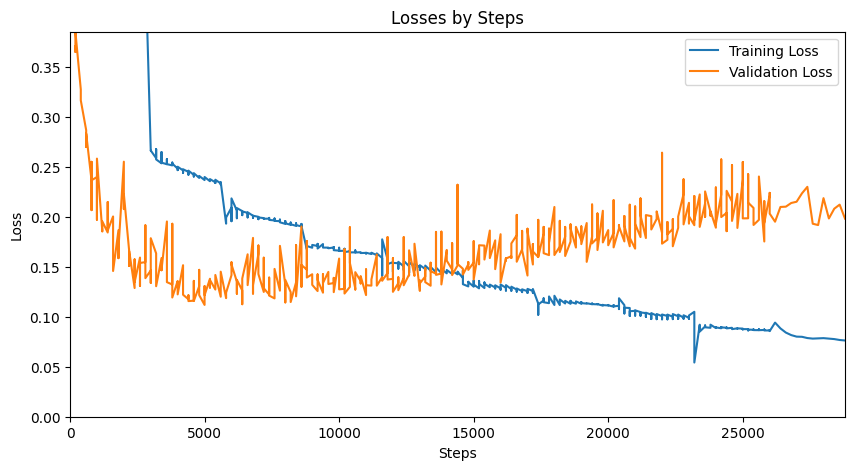

<Figure size 640x480 with 0 Axes>

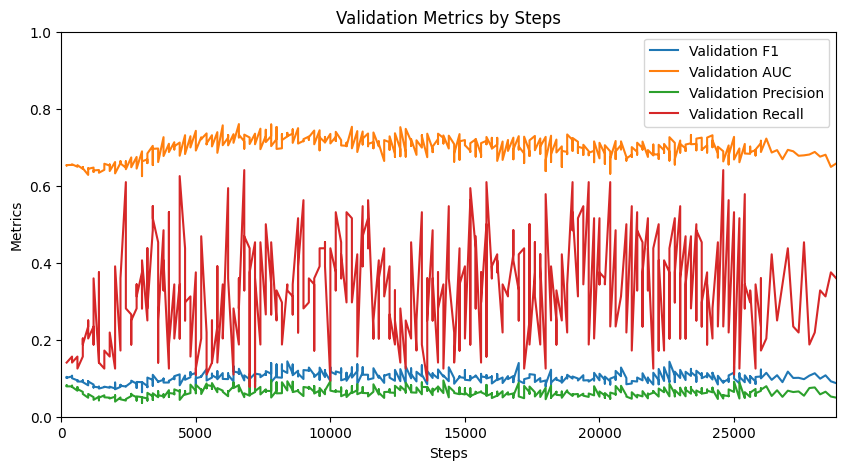

<Figure size 640x480 with 0 Axes>

In [ ]:
version = "v2"
folder = f"/content/classification/{model_name}_{version}"
model_save_path = f"{folder}/model/"
metrics_save_path = f"{folder}/metrics/"
num_labels = 1
epochs = 10
lr = 0.00001
train_batch_size = 32
eval_batch_size = 512
warmup_steps = 2600
weight_decay = 0.0
evaluation_steps = 200 # How many steps before you eval
optimizer_class = "lion"
scheduler = 'warmupcosinewithhardrestarts' # constantlr, warmupconstant, warmuplinear, warmupcosine, warmupcosinewithhardrestarts

trainer = CrossEncoderTrainer(
    project_name = "colab_test",
    model_name = model_name,
    num_labels = num_labels,
    epochs = epochs,
    lr=lr,
    train_batch_size = train_batch_size,
    eval_batch_size = eval_batch_size,
    warmup_steps = warmup_steps,
    weight_decay = weight_decay,
    evaluation_steps = evaluation_steps,
    optimizer_class = optimizer_class,
    model_save_path = model_save_path,
    metrics_save_path=metrics_save_path,
    scheduler = scheduler,
    version = version
)

trainer.train(
    data["train"],
    data["validation"]
)

trainer.plot_validation_metrics()



In [ ]:
trainer = CrossEncoderTrainer(
    project_name = "colab_test",
    model_name = model_name,
    num_labels = num_labels,
    epochs = epochs,
    lr=lr,
    train_batch_size = train_batch_size,
    eval_batch_size = eval_batch_size,
    warmup_steps = warmup_steps,
    weight_decay = weight_decay,
    evaluation_steps = evaluation_steps,
    optimizer_class = optimizer_class,
    model_save_path = model_save_path,
    metrics_save_path=metrics_save_path,
    scheduler = scheduler
)
print(model_name, model_save_path)

Model loaded successfully
cross-encoder/mmarco-mMiniLMv2-L12-H384-v1 /content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/


Model loaded successfully


<Figure size 1000x800 with 0 Axes>

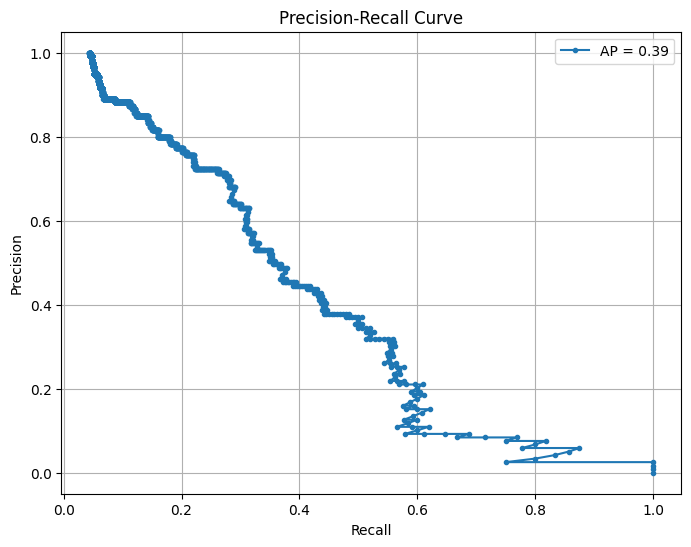

Test Scores:  {'f1_per_class': [0.9738461538461538, 0.43333333333333335], 'precision_per_class': [0.9742208541746825, 0.4297520661157025], 'recall_per_class': [0.9734717416378316, 0.4369747899159664], 'auc_per_class': [0.863588341911159, 0.863588341911159], 'f1': 0.43333333333333335, 'precision': 0.4297520661157025, 'recall': 0.4369747899159664, 'auc': 0.863588341911159, 'weighted_precision': 0.7019864601451925, 'weighted_recall': 0.705223265776899, 'weighted_f1': 0.7035897435897436}


<Figure size 640x480 with 0 Axes>

In [ ]:
scores, best_threshold = trainer.test(
    data["test"],
    f"{folder}/metrics/test_results.json",
    data["validation"]
)

In [ ]:
!gsutil -m cp -r  {folder} gs://mddi-reach-conversation/{model_name}_{version}

Copying file:///content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/metrics/classification_evaluation_cross-encoder_mmarco-mMiniLMv2-L12-H384-v1_v2_results.json [Content-Type=application/json]...
Copying file:///content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/metrics/test_results.json [Content-Type=application/json]...
Copying file:///content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/special_tokens_map.json [Content-Type=application/json]...
Copying file:///content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/model.safetensors [Content-Type=application/octet-stream]...
Copying file:///content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/sentencepiece.bpe.model [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"par

In [ ]:
import os
import torch
from transformers import AutoModelForSequenceClassification
model_name = "cross-encoder/mmarco-mMiniLMv2-L12-H384-v1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
version = "v2"
folder = f"/content/classification/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1_v2/model/"

model = AutoModelForSequenceClassification.from_pretrained(
            folder)

for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)
model.to(device)

roberta.embeddings.word_embeddings.weight torch.Size([250002, 384]) True
roberta.embeddings.position_embeddings.weight torch.Size([514, 384]) True
roberta.embeddings.token_type_embeddings.weight torch.Size([1, 384]) True
roberta.embeddings.LayerNorm.weight torch.Size([384]) True
roberta.embeddings.LayerNorm.bias torch.Size([384]) True
roberta.encoder.layer.0.attention.self.query.weight torch.Size([384, 384]) True
roberta.encoder.layer.0.attention.self.query.bias torch.Size([384]) True
roberta.encoder.layer.0.attention.self.key.weight torch.Size([384, 384]) True
roberta.encoder.layer.0.attention.self.key.bias torch.Size([384]) True
roberta.encoder.layer.0.attention.self.value.weight torch.Size([384, 384]) True
roberta.encoder.layer.0.attention.self.value.bias torch.Size([384]) True
roberta.encoder.layer.0.attention.output.dense.weight torch.Size([384, 384]) True
roberta.encoder.layer.0.attention.output.dense.bias torch.Size([384]) True
roberta.encoder.layer.0.attention.output.LayerNorm.

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 384, padding_idx=1)
      (position_embeddings): Embedding(514, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=

In [ ]:
model_version_name = model_name.replace("/", "_") + "_" + version

def create_batch(dataset, batch_size=None, shuffle=True, stratified=True):


    # If shuffle is True, shuffle the dataset first
    if shuffle:
        dataset = dataset.shuffle(seed=42)  # Shuffle with a seed for reproducibility

    # Set the format for Hugging Face datasets (before passing to DataLoader)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    if stratified:
        # Get the labels and calculate the class distribution
        labels = np.array(dataset['label'])  # Convert labels to numpy array
        class_counts = torch.tensor([sum(labels == i) for i in set(labels)])  # Count each class
        class_weights = 1.0 / class_counts  # Calculate inverse frequency (more weight for less frequent classes)
        sample_weights = class_weights[labels]  # Assign a weight to each sample based on its label

        # Create a WeightedRandomSampler for stratified sampling
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

        # Create the DataLoader using the sampler
        dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    else:
        # Without stratified sampling
        dataloader = DataLoader(dataset, batch_size=batch_size)

    return dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
test_batchloader = create_batch(test_dataloader, batch_size=2, shuffle=False, stratified=False)

label = []
test_pred_scores = []
for batch in tqdm(
    test_batchloader, desc="Iteration", smoothing=0.05
):
    model.eval()
    features = {k: torch.Tensor(v).to(device) for k, v in batch.items() if k != 'label'}
    model_predictions = model(**features, return_dict=True)
    label += batch["label"].tolist()
    logits = torch.sigmoid(model_predictions.logits).detach().cpu().numpy().tolist()
    test_pred_scores.extend(logits)


Iteration:   0%|          | 0/1360 [00:00<?, ?it/s]

In [ ]:
test_batchloader = create_batch(test_dataloader, batch_size=2, shuffle=False, stratified=False)

label = []
test_pred_scores = []
for batch in tqdm(
    test_batchloader, desc="Iteration", smoothing=0.05
):
    model.eval()
    features = {k: torch.Tensor(v).to(device) for k, v in batch.items() if k != 'label'}
    model_predictions = model(**features, return_dict=True)
    label += batch["label"].tolist()
    logits = torch.sigmoid(model_predictions.logits).detach().cpu().numpy().tolist()
    test_pred_scores.extend(logits)


prediction = [pred[0] for pred in test_pred_scores]
test_data["score"] = prediction

best_f1 = 0
best_threshold = 0

for threshold in np.arange(0.01, 1.0, 0.01):
    test_data["pred"] = (np.array(prediction) > threshold).astype(int)

    score = f1_score(test_data["label"], test_data["pred"])
    if score > best_f1:
        best_f1 = score
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1 Score: {best_f1}")
test_data["pred"] = (np.array(prediction) > best_threshold).astype(int)


from sklearn.metrics import precision_score, recall_score, f1_score
def compute_metrics(true_labels, prediction):
    metrics = {}
    metrics["f1"] = f1_score(true_labels, prediction)
    metrics["precision"] = precision_score(true_labels, prediction)
    metrics["recall"] = recall_score(true_labels, prediction)
    metrics["f1_weighted"] = f1_score(true_labels, prediction, average = "weighted")
    metrics["recall_weighted"] = recall_score(true_labels,prediction, average = "weighted")
    metrics["precision_weighted"] = precision_score(true_labels, prediction, average = "weighted")
    metrics["f1_marco"] = f1_score(true_labels, prediction, average = "macro")
    metrics["precision_marco"] = precision_score(true_labels, prediction, average = "macro")
    metrics["recall_marco"] = recall_score(true_labels, prediction, average = "macro")

    return metrics

compute_metrics(test_data["label"], test_data["pred"])


Iteration:   0%|          | 0/1360 [00:00<?, ?it/s]

Best Threshold: 0.27, Best F1 Score: 0.43333333333333335


{'f1': 0.43333333333333335,
 'precision': 0.4297520661157025,
 'recall': 0.4369747899159664,
 'f1_weighted': 0.9501987179487178,
 'recall_weighted': 0.95,
 'precision_weighted': 0.9504003446971021,
 'f1_marco': 0.7035897435897436,
 'precision_marco': 0.7019864601451925,
 'recall_marco': 0.705223265776899}

In [ ]:
test_batchloader = create_batch(test_dataloader, batch_size=2, shuffle=False, stratified=False)

label = []
test_pred_scores = []
for batch in tqdm(
    test_batchloader, desc="Iteration", smoothing=0.05
):
    model.eval()
    features = {k: torch.Tensor(v).to(device) for k, v in batch.items() if k != 'label'}
    model_predictions = model(**features, return_dict=True)
    label += batch["label"].tolist()
    logits = torch.sigmoid(model_predictions.logits).detach().cpu().numpy().tolist()
    test_pred_scores.extend(logits)



Iteration:   0%|          | 0/1360 [00:00<?, ?it/s]

Best Threshold: 0.92, Best F1 Score: 0.6666666666666666


In [ ]:
test_data.to_csv(f"/content/test_results_{model_version_name}.csv", index=False)

In [ ]:
!gsutil -m cp  "/content/test_results_{model_version_name}.csv" gs://mddi-reach-conversation/

Copying file:///content/test_results_cross-encoder_mmarco-mMiniLMv2-L12-H384-v1_v2.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/8.8 MiB.                                      


# Test Results Analysis

In [ ]:
!gsutil -m cp gs://mddi-reach-conversation/test_results_cross-encoder_mmarco-mMiniLMv2-L12-H384-v1_v2.csv  "/content/test_results_cross-encoder_mmarco-mMiniLMv2-L12-H384-v1_v2.csv"

Copying gs://mddi-reach-conversation/test_results_cross-encoder_mmarco-mMiniLMv2-L12-H384-v1_v2.csv...
\ [1/1 files][  8.8 MiB/  8.8 MiB] 100% Done                                    
Operation completed over 1 objects/8.8 MiB.                                      


In [ ]:
import pandas as pd
test_data = pd.read_csv(f"/content/test_results_cross-encoder_mmarco-mMiniLMv2-L12-H384-v1_v2.csv")
test_data.head()

,pid,chat_group_id,timestamp,topic,content,topic_group,context,group_user,group,user,stance,human_label,agreement,label,label_description,score,pred
0,b2f4b6c1-9b3b-49a8-969a-f45a2ec03930,1,2023/02/15 10:04:00,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,"It is just a one off payment. In the long run,...",budget,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,1b2f4b6c1-9b3b-49a8-969a-f45a2ec03930,1,b2f4b6c1-9b3b-49a8-969a-f45a2ec03930,I support the Government's efforts to integrat...,no opinion,unanimous,0,NaN,0.002055,0
1,b083d46c-1613-4905-b737-1b086bd1e7e6,1,2023/02/15 10:09:00,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,Agree ! Cannot keeping depending on Garmen for...,budget,"It is just a one off payment. In the long run,...",1b083d46c-1613-4905-b737-1b086bd1e7e6,1,b083d46c-1613-4905-b737-1b086bd1e7e6,I support the Government's efforts to integrat...,no opinion,majority,0,NaN,0.000458,0
2,57659f24-de26-4099-a526-4a62032d2f76,1,2023/02/15 10:10:00,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,I like the part on increasing the stamp duty f...,budget,Agree ! Cannot keeping depending on Garmen fo...,157659f24-de26-4099-a526-4a62032d2f76,1,57659f24-de26-4099-a526-4a62032d2f76,I support the Government's efforts to integrat...,no opinion,unanimous,0,NaN,0.000226,0
3,57659f24-de26-4099-a526-4a62032d2f76,1,2023/02/15 10:11:00,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,But more can be done for those multiple luxury...,budget,I like the part on increasing the stamp duty ...,157659f24-de26-4099-a526-4a62032d2f76,1,57659f24-de26-4099-a526-4a62032d2f76,I support the Government's efforts to integrat...,no opinion,unanimous,0,NaN,0.000160,0
4,b6f0bac9-0a7a-44b9-b577-50dc4fdb051e,1,2023/02/15 10:14:00,📢 *Topic* 📢\n\n*BUDGET 2023 - MOVING FORWARD I...,we already increased the tax such owners must pay,budget,But more can be done for those multiple luxur...,1b6f0bac9-0a7a-44b9-b577-50dc4fdb051e,1,b6f0bac9-0a7a-44b9-b577-50dc4fdb051e,I support the Government's efforts to integrat...,no opinion,unanimous,0,NaN,0.000091,0


In [ ]:
error = test_data[test_data["pred"]!=test_data["label"]]
error.groupby("stance")[["label", "pred"]].mean()

,label,pred
stance,,
I have lost confidence in the Government's processes,0.977528,0.022472
I support the Government's efforts to integrate training with job placement,0.956522,0.043478


In [ ]:
error.groupby("stance")["pred"].count()/test_data.groupby("stance")["label"].count()

In [ ]:
def compute_metrics(true_labels, prediction):
    metrics = {}
    metrics["f1"] = f1_score(true_labels, prediction)
    metrics["precision"] = precision_score(true_labels, prediction)
    metrics["recall"] = recall_score(true_labels, prediction)
    metrics["f1_weighted"] = f1_score(true_labels, prediction, average = "weighted")
    metrics["recall_weighted"] = recall_score(true_labels,prediction, average = "weighted")
    metrics["precision_weighted"] = precision_score(true_labels, prediction, average = "weighted")
    metrics["f1_marco"] = f1_score(true_labels, prediction, average = "macro")
    metrics["precision_marco"] = precision_score(true_labels, prediction, average = "macro")
    metrics["recall_marco"] = recall_score(true_labels, prediction, average = "macro")

    return metrics

In [ ]:
ps_metrics = {}
from sklearn.metrics import precision_score, recall_score, f1_score

for position_statement in list(test_data.stance.unique()):
    stance_df= test_data[test_data["stance"]==position_statement]
    ps_metrics[position_statement] = compute_metrics(stance_df["label"], stance_df["pred"])

ps_metrics

{"I support the Government's efforts to integrate training with job placement": {'f1': 0.20689655172413793,
  'precision': 0.75,
  'recall': 0.12,
  'f1_weighted': 0.9833354375457416,
  'recall_weighted': 0.9877398720682303,
  'precision_weighted': 0.9850729183751572,
  'f1_marco': 0.600359369066474,
  'precision_marco': 0.8691239316239316,
  'recall_marco': 0.5597298757428417},
 "I have lost confidence in the Government's processes": {'f1': 0.13592233009708737,
  'precision': 0.7777777777777778,
  'recall': 0.07446808510638298,
  'f1_weighted': 0.853866272938811,
  'recall_weighted': 0.8945497630331753,
  'precision_weighted': 0.8826627944742427,
  'f1_marco': 0.5398854552693638,
  'precision_marco': 0.8367930805056554,
  'recall_marco': 0.5359007092198581}}

In [ ]:
import numpy as np

best_f1 = 0
best_threshold = 0

for threshold in np.arange(0.01, 1.0, 0.01):
    test_data["pred"] = (np.array(test_data["score"] ) > threshold).astype(int)
    agg_test_results = (
        test_data.groupby(["group_user", "stance"])[["pred", "label"]]
        .max()
        .reset_index()
    )
    score = f1_score(agg_test_results["label"], agg_test_results["pred"])
    if score > best_f1:
        best_f1 = score
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1 Score: {best_f1}")

Best Threshold: 0.92, Best F1 Score: 0.6666666666666666


In [ ]:
test_data["pred"] = (np.array(test_data["score"] ) > best_threshold).astype(int)
agg_test_results = (
    test_data.groupby(["group_user", "stance"])[["pred", "label","agreement"]]
    .max()
    .reset_index()
)

compute_metrics(agg_test_results["label"], agg_test_results["pred"])

{'f1': 0.6666666666666666,
 'precision': 0.8888888888888888,
 'recall': 0.5333333333333333,
 'f1_weighted': 0.9612761667556188,
 'recall_weighted': 0.9653679653679653,
 'precision_weighted': 0.9633009633009634,
 'f1_marco': 0.8242009132420092,
 'precision_marco': 0.9286786786786787,
 'recall_marco': 0.7643518518518518}

In [ ]:
ps_metrics = {}
from sklearn.metrics import precision_score, recall_score, f1_score

for position_statement in list(agg_test_results.stance.unique()):
    stance_df= agg_test_results[agg_test_results["stance"]==position_statement]
    ps_metrics[position_statement] = compute_metrics(stance_df["label"], stance_df["pred"])

ps_metrics

{"I have lost confidence in the Government's processes": {'f1': 0.7692307692307693,
  'precision': 1.0,
  'recall': 0.625,
  'f1_weighted': 0.9631199140181176,
  'recall_weighted': 0.9666666666666667,
  'precision_weighted': 0.967843137254902,
  'f1_marco': 0.875633348687241,
  'precision_marco': 0.9823529411764707,
  'recall_marco': 0.8125},
 "I support the Government's efforts to integrate training with job placement": {'f1': 0.5454545454545454,
  'precision': 0.75,
  'recall': 0.42857142857142855,
  'f1_weighted': 0.9598996957087559,
  'recall_weighted': 0.9645390070921985,
  'precision_weighted': 0.9598410726303257,
  'f1_marco': 0.7635021804763502,
  'precision_marco': 0.8604014598540146,
  'recall_marco': 0.7105543710021321}}

In [ ]:
agreement_metrics = {}
from sklearn.metrics import precision_score, recall_score, f1_score

for agreement in list(agg_test_results.agreement.unique()):
    agreement_df= agg_test_results[agg_test_results["agreement"]==agreement]
    agreement_metrics[agreement] = compute_metrics(agreement_df["label"], agreement_df["pred"])

agreement_metrics

{'majority': {'f1': 0.3333333333333333,
  'precision': 1.0,
  'recall': 0.2,
  'f1_weighted': 0.9418914418914419,
  'recall_weighted': 0.9560439560439561,
  'precision_weighted': 0.957997557997558,
  'f1_marco': 0.6553030303030303,
  'precision_marco': 0.9777777777777779,
  'recall_marco': 0.6},
 'unanimous': {'f1': 0.7777777777777778,
  'precision': 0.875,
  'recall': 0.7,
  'f1_weighted': 0.9699503210953592,
  'recall_weighted': 0.9714285714285714,
  'precision_weighted': 0.9699675324675325,
  'f1_marco': 0.8812553011026294,
  'precision_marco': 0.9261363636363636,
  'recall_marco': 0.8461538461538461}}